# Paediatric Appendicitis
*MS 4 - Group 23*


**Imports and Data Download:**

In [ ]:
import numpy as np
import pandas as pd
import hashlib

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy.stats as ss
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from torch.utils.data import Dataset, DataLoader

In [ ]:
google_colab = True

if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    file_path = '/content/drive/MyDrive/AC209b_Paediatric_Appendicitis/app_data_scaled_one_to_many.pkl'
    device = "cpu"
else:
    file_path = 'app_data_scaled_one_to_many.pkl'
    device = "cuda"

df = pd.read_pickle(file_path)

Mounted at /content/drive


# Table of Contents
1. [Introduction and Problem Statement](#intro)
2. [Comprehensive EDA Review and Preprocessing](#eda)

 2.1 Data Description

 2.2. Tabular Data: EDA and Preprocessing

 2.3. Multi-View Image Data: EDA and Preprocessing

 2.4. Merging Tabular and Image Data

3. [Baseline Model Selection and Justification](#baseline)

    3.1 Model Architecture

    3.2 Justification

    3.3 Preprocessing

    3.4 Training Setup

    3.5 Metrics for Evaluation

    3.6 Code

4. [Analysis of Results](#analysis)
5. [Next Steps](#next_steps)
6. [Final Model Pipeline Setup ](#final)

<a name="intro"></a>
**1. Introduction**
---

Interpretable machine learning is becoming increasingly important in healthcare, where mere prediction scores are often insufficient for doctors making high-stakes decisions. To address this challenge, researchers are developing machine learning models that not only predict outcomes but also offer interpretable insights into why a decision is made, helping healthcare practitioners trust and effectively use AI support in clinical settings.

[Marcinkevics et al.](https://arxiv.org/abs/2302.14460v2) contributed to this effort by developing a concept bottleneck model (CBM) that assists doctors in diagnosing pediatric appendicitis. Their model identifies relevant concepts - such as, e.g., visibility of the appendix, wall thickness, the presence of free fluid, etc. - from multi-view ultrasound images and presents these concepts to doctors, enabling faster and more informed decision-making.

Inspired by their work, our project aims to explore a complementary direction: providing visual interpretations of the multi-view data to assist in diagnosis. Therefore, rather than re-implementing Marcinkevics et al.'s proposed CBM structure, we develop a "simpler" multi-modal model that integrates both tabular clinical data and multi-view ultrasound images to directly predict diagnoses. This model architecture is then used in conjunction with visual interpretability methods (such as GradCAM) to highlight the regions in the different images that are most influential to the model's prediction.

By explicitly showing where the model "looks" when making its decision, rather than just being presented with the relevent concepts, could be immensely helpful for doctors when needing to make quick, high-stakes decisions. This need is further supported by the fact that some patients have up to 34 different ultra-sound views; an insight into which view is the most important one and why could make the decision-making process a lot more efficient and easier. Through this approach, we aim to contribute to the effort of bridging the gap between raw model outputs and actionable explanations, moving closer to practical, interpretable AI tools for real-world healthcare applications.

**EDA Insights and Problem Statement**

Our exploratory data analysis revealed that the tabular clinical features in the pediatric appendicitis dataset are highly informative: many features are significantly correlated with the diagnosis, and a simple baseline model trained only on tabular data already achieved strong predictive performance. This finding shifts our perspective on the role of the image data. Rather than treating the images as a primary source of diagnostic information, it becomes clear that the images must provide *additional, non-redundant insights* that go beyond what is already captured by the clinical features.

This introduces a key challenge: since the tabular features are so predictive, the model might learn to overrely on them and underutilize the more complex image data. To achieve meaningful visual interpretability - highlighting which views of the multi-view ultrasound images are most influential in diagnosis - it is crucial that the model effectively integrates and leverages the image information in its decision-making process.

Addressing this challenge serves two goals: improving predictive performance through multi-modal learning, and providing meaningful, interpretable visual explanations. Our project is therefore guided by the following main research question and sub-questions:



**Main Research Question**

**How can a multi-modal model, combining clinical tabular data and multi-view ultrasound images, be designed to effectively provide visual explanations that assist doctors in diagnosing pediatric appendicitis?**

We break this into two sub-questions:



1. **Balancing Multi-Modal Contributions**: How can we integrate highly predictive clinical tabular features and complex ultrasound image data in a way that ensures both modalities contribute meaningfully and complimentary to the diagnostic process?


2. **Adapting Visual Interpretability for Multi-View Images**: How can traditional visual interpretability methods, typically developed for single-view images, be adapted to multi-view ultrasound data to identify the most influential views and highlight key regions that drive model predictions?


By tackling the dual challenges of balancing multi-modal learning and extending visual interpretability to multi-view imaging data, we aim to contribute both methodologically and practically to the development of trustworthy, interpretable AI for clinical decision support.


<a name="eda"></a>
**2. Comprehensive EDA Review and Preprocessing**
---

**2.1 Data Description**

 Our dataset comes from the UCI Machine Learning Repository and includes 782 pediatric patients with tabular clinical data and 1,709 ultrasound images. Each patient is linked to between 1 and 34 image views, creating a one-to-many structure. All ultrasound images are correctly mapped to their corresponding tabular records using the US_Number field. This setup will enable a multimodal modeling pipeline that combines both image and clinical data for diagnosis.

**2.2 Tabular Data: EDA and Preprocessing**

2.2.1. *Key Findings from EDA*

Our exploratory analysis of the tabular clinical data revealed that many features are highly predictive of pediatric appendicitis. Basic models trained solely on the tabular data already achieved strong performance, emphasizing the importance of careful feature selection and preparation to maximize predictive power while avoiding redundancy.

Missingness analysis (Figure 1) showed that several features had high rates of missing data. To maintain data reliability, we retained only features with less than 50% missingness. Features exceeding this threshold were excluded, as imputing them could introduce bias or instability into the models.

![My Image](https://drive.google.com/uc?id=1DsY1EOG4sGk49n6FO-pJzYQEddD24tvb)
**Figure 1.** Bar plot showing the number of missing values per feature in the tabular dataset.

Boxplots (Figure 2) of numeric predictors, such as CRP, WBC_Count, Neutrophil_Percentage, and Appendix_Diameter, showed clear elevation in patients diagnosed with appendicitis, validating their clinical relevance. For categorical features, grouped bar plots (Figure 3) indicated strong differences in variables like Free_Fluids, Nausea, and Appendix_on_US between diagnostic groups.

![My Image](https://drive.google.com/uc?id=1SOA5t2imAEIrot7U-pLzWb9sg77K4jVt)
**Figure 2.** Boxplots showing the distribution of key numeric predictors stratified by diagnosis.

![My Image](https://drive.google.com/uc?id=1m2fdcgNU9flZ2sMt7_0p3USfLwK_aLSe)
**Figure 3.** Bar plots showing the distribution of key categorical predictors by diagnosis group.

Correlation analyses confirmed that most numeric features were not highly collinear, with the exception of the expected strong relationship between the Pediatric Appendicitis Score and Alvarado Score (r = 0.84). Similarly, Cramér’s V analysis showed limited redundancy among categorical predictors, supporting the decision to keep most features for modeling.

Finally, Sex, Age, and BMI were flagged as important potential confounders based on clinical reasoning and included to control for bias in downstream models.


*2.2.2. Feature Engineering Process*

Based on the EDA findings, the following feature selection and transformation steps were implemented:

- Feature Dropping: We removed features that were redundant, clinically irrelevant for real-time diagnosis, or risked data leakage. These included Height, Weight, Length_of_Stay, Diagnosis_Presumptive, and several bloodwork measures (e.g., RBC_Count, Hemoglobin) whose predictive signal was already captured in retained variables.

- Handling Missing Data:

  - For features with informative missingness (e.g., Appendix_Diameter), we created binary missingness flags instead of direct imputation to preserve potential diagnostic signals.
  - K-nearest neighbors (KNN) imputation was used for features with strong correlations to other variables, preserving clinical relationships.
  - Median imputation (for numerical features) and mode imputation (for categorical features) were used for features with weaker correlations or seemingly random missingness.
  - A single row with a missing target label was dropped to avoid introducing noise into the model.

- Encoding and Normalization:
  - Numeric features were standardized to avoid scale imbalances that could bias model training.
  - Categorical features were one-hot encoded where appropriate, considering class imbalance and diagnostic relevance.


*2.2.3. Final Preprocessing Steps*

After completing the feature selection and missing data handling steps, the tabular dataset required minimal further preprocessing. To prepare the data for modeling, we filled any remaining missing values with 0, which is appropriate given that missingness is already indicated by corresponding binary flags and the features are standardized. No additional transformations were necessary, and the processed dataset was used directly as model input.


**2.3. Multi-View Image Data: EDA and Preprocessing**

*2.3.1. Key Findings from EDA*

Our exploratory analysis of the ultrasound image data revealed several important characteristics that shaped our preprocessing strategy. Each patient was linked to between 1 and 34 ultrasound images, resulting in a highly variable number of views across the dataset. We also observed considerable variation in image quality, brightness, and anatomical focus, with some views clearly capturing the appendix and others appearing more ambiguous. Importantly, the metadata linking each image to a patient through the US_Number field was consistent, allowing for reliable alignment of image and tabular data.


*2.3.2. Feature Engineering Process*

A notable challenge during preprocessing was the presence of annotation overlays on many of the ultrasound images. These overlays, often added by radiologists to indicate measurements or highlight regions of interest, introduced visual artifacts that could bias model learning if left uncorrected. To address this, we developed an inpainting pipeline using DeepFill v2, a state-of-the-art deep generative model for image completion. Before applying inpainting, we cropped all images to center the relevant anatomical regions and remove extraneous borders, standardizing the fields of view across patients. The inpainting model was then used to fill in the annotation regions, producing clean, naturalistic ultrasound images suitable for downstream machine learning tasks.

Following annotation removal and cropping, all images were resized to a consistent resolution and pixel intensities were normalized to the [0,1] range to standardize input distributions. Basic data augmentations, such as random horizontal flips and small rotations, were considered to enhance generalization without distorting the anatomical structures. After these preprocessing steps, the cleaned and standardized images were mapped back to their corresponding patient IDs, ensuring seamless integration with the associated clinical tabular data.

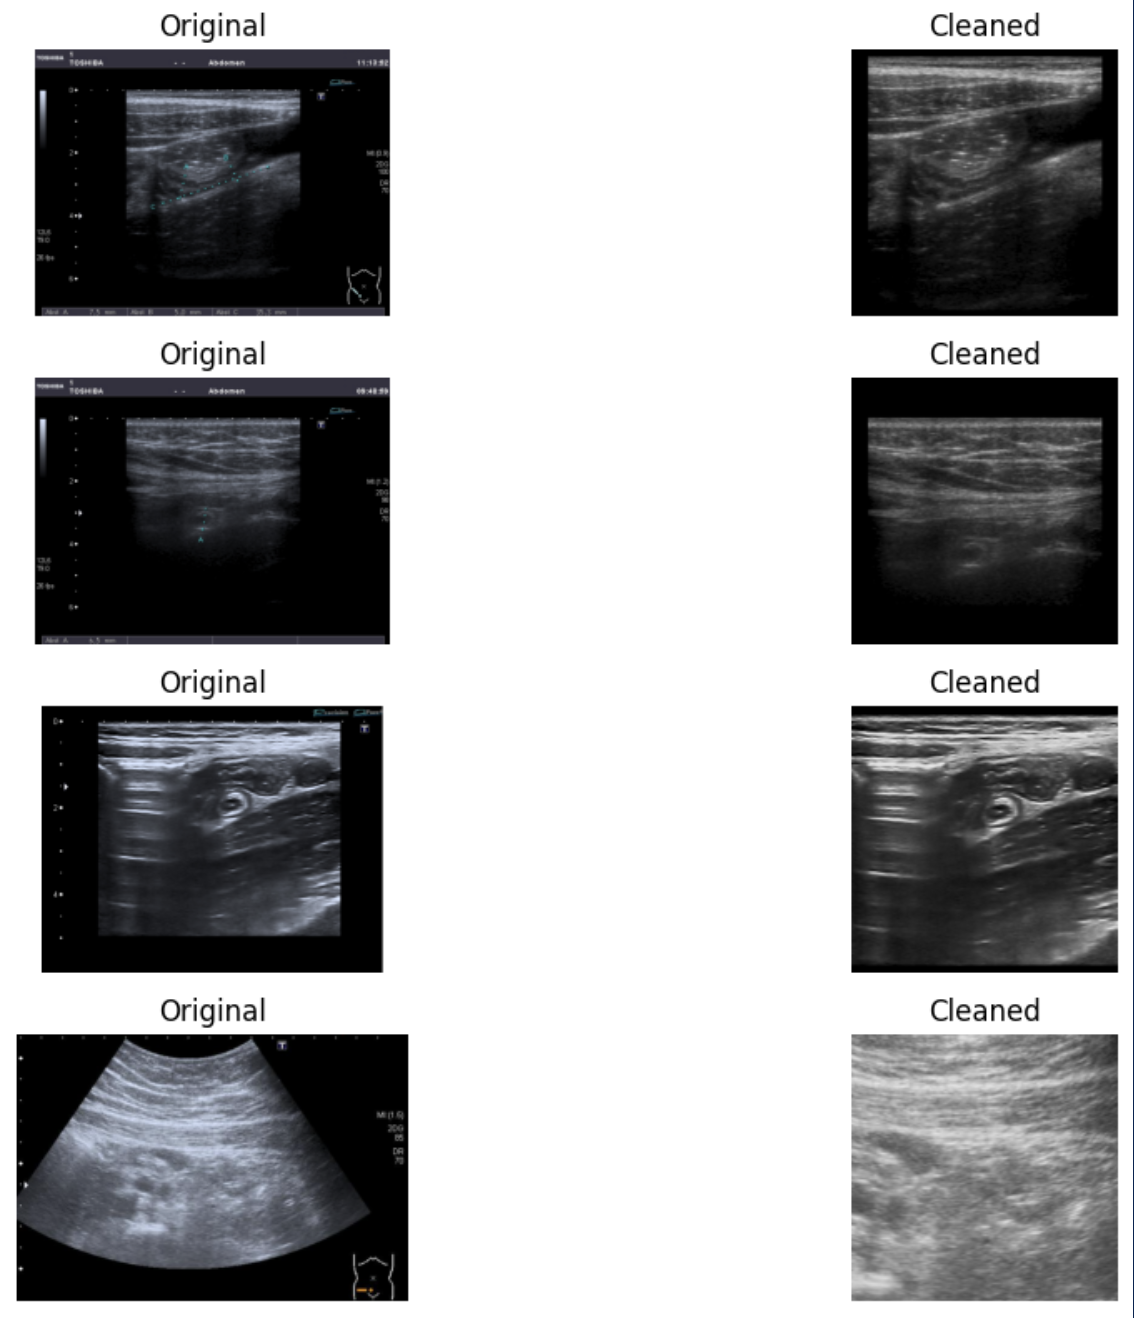

**Figure 4.** Displays the ultrasound images before annotation removal, after annotation removal, and after cropping.



*2.3.3. Handling Duplicates in Multi-View Data*

It turns out that the dataset includes a lot of duplicate images per patient. In the next section will visualize this issue. Acting on these insights, we decided to remove duplicates and only keep the non-duplicate views per patients. This particular preprocessing step will be performed in the `prepare_data` function.

As there are several patients (patient 10, for instance) who have multiple *unique* views, we need to find a way to allow the model to consider these multiple views at once for every patient. Thus, we want one single row in the dataset per patient (this also makes sense as we are working on classification task! It doesn't make sense to treat each individual view in this multi-view setting as a separate instance, as that would mean that potentially relevant infromation is lost for classification). This implies that we need to deal with a variable amount of data for every patient, as the number of views per patient is not consistent. This requires some careful considerations for how we preprocess and prepare our dataset for training, as well as in the way we use this variable-length image data in our model. In this section, we address our decision-making process in how we prepare our dataset.

**Step 1: Assess the existence of duplicates**

*Approach:* we use a hash function on the images to see whether multiple images will be mapped to the same hash.

In [ ]:
def determine_number_of_duplicates(df, patient_number):

  def image_hash(img):
        if isinstance(img, Image.Image):
            img = np.array(img)  # convert to np array
        return hashlib.md5(img.tobytes()).hexdigest()

  series = df[df["US_Number"] == patient_number]["normalized_image"]

  # Apply the hash
  img_hashes = series.apply(image_hash)

  # Check for duplicates
  duplicates = img_hashes.duplicated(keep=False)  # or keep='first' to flag only the second+ ones

  # Example: Get only the duplicate images
  duplicate_images = series[duplicates]
  print(f"Patient #{patient_number} has {len(duplicate_images)} duplicate views (with a total of {len(series)} views).")

determine_number_of_duplicates(df, 1)
determine_number_of_duplicates(df, 10)
determine_number_of_duplicates(df, 250)

Patient #1 has 14 duplicate views (with a total of 14 views).
Patient #10 has 0 duplicate views (with a total of 2 views).
Patient #250 has 10 duplicate views (with a total of 10 views).


**Duplicate Views**

Some of the patients have duplicate views! We decide to remove them. We visualize these duplicates for one patient (#250) below. We also visualize the fact that some patients have unique views (patient #10).

In [ ]:
def show_3x3_grid(df, patient_number, idx):
    """
    Display a 3x3 grid of images starting from index `idx` in a pandas Series.
    """

    series = df[df["US_Number"] == patient_number]["normalized_image"]

    if len(series) > 6:
        n_rows = 3
    elif len(series) > 3:
        n_rows = 2
    else:
        n_rows = 1

    fig, axs = plt.subplots(n_rows, 3, figsize=(9, n_rows * 3))
    axs = axs.flatten()

    for i in range(n_rows * 3):
        if idx + i >= len(series):
            axs[i].axis('off')  # hide extra axes if out of bounds
            continue

        img = series.iloc[idx + i]

        # If it's a PIL image, convert to array for plotting
        if isinstance(img, Image.Image):
            img = np.array(img)

        axs[i].imshow(img, cmap='gray' if img.ndim == 2 else None)
        axs[i].axis('off')
        axs[i].set_title(f'Idx {idx + i}')

    plt.suptitle(f"Patient {patient_number}")
    plt.tight_layout()
    plt.show()

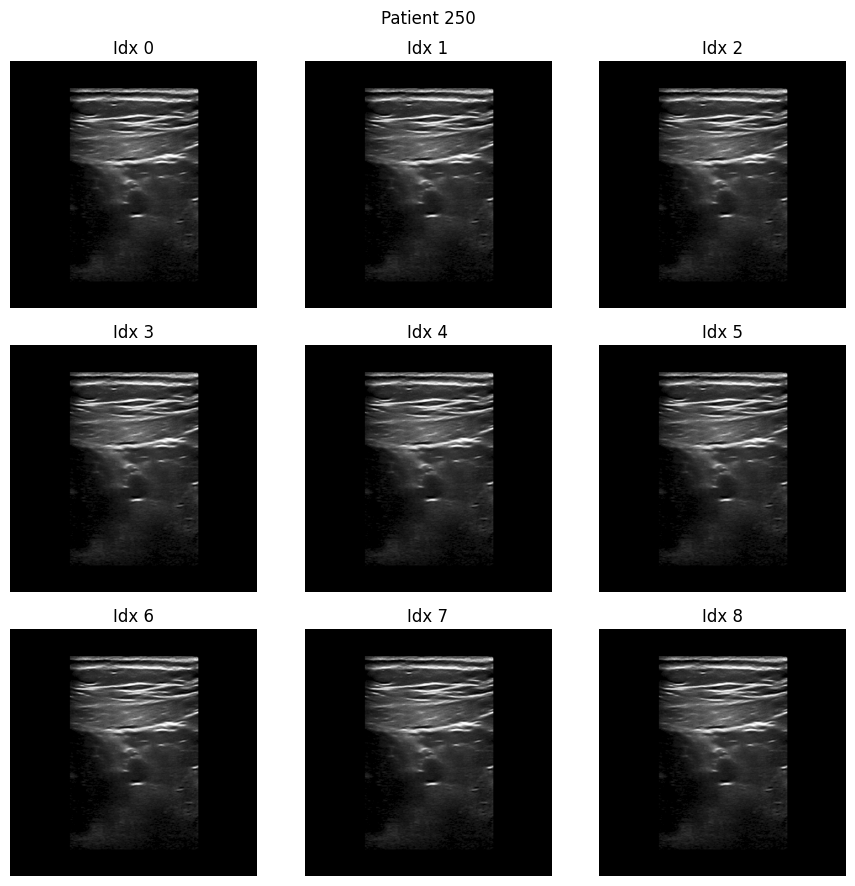

In [ ]:
show_3x3_grid(df, 250, 0)

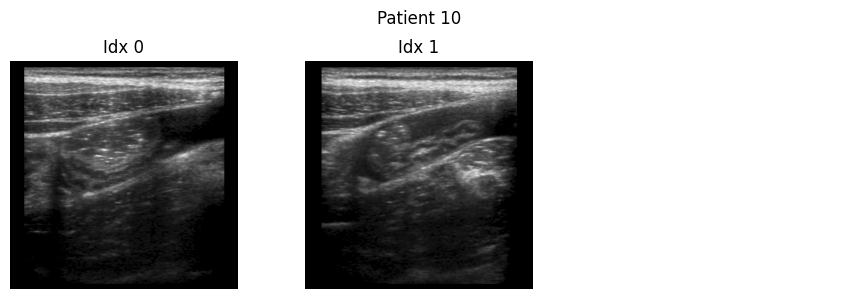

In [ ]:
show_3x3_grid(df, 10, 0)

**Step 2: Prepare the Dataset for Training**

Currently, patients with multiple views have multiple rows in the dataset (with one row per view - the image being the only value in the row that is different). This is undesired, as we only want a single row per patient. We therefore aggregate these multiple, almost identical rows into a single one. If these rows have differing values in the `normalized_image` column, new columns will be created to account for those unique views. This has the consequence that the dataset will be "widened" (i.e., new columns will be added) to account for the maximum number of views a patient has in this dataset.

This aggregation process results in duplicate views being removed. It also results in the fact that every patient will have the same number of columns (=34), with some columns being empty. This also means that we later need to account for this - in essence - padding. We will do this in the DataLoader.

In [ ]:
def prepare_data(df):

  # Convert to just one row per patient - multiple columns for multiple views!
  varying = ["normalized_image"]
  constant = df.columns[:-1] # remove normalized_image

  # Step 1: Build aggregation dictionary
  agg_dict = {col: 'first' for col in constant}
  for col in varying:
      agg_dict[col] = lambda x: list(x)

  # Step 2: Group and aggregate
  df_agg = df.groupby("US_Number", as_index=False).agg(agg_dict)

  # Step 3: Expand varying columns into wide format and remove duplicates
  for col in varying:
      max_len = df_agg[col].str.len().max()
      expanded = pd.DataFrame(df_agg[col].tolist(), index=df_agg.index)
      expanded.columns = [f"{col}_{i}" for i in range(max_len)]
      df_agg = pd.concat([df_agg.drop(columns=col), expanded], axis=1)


  # Define the target and irrelevant columns
  irrelevant_cols = ['Diagnosis', 'Diagnosis_encoded', 'Severity', 'Management', 'image_path', 'US_Number']

  binary_categoricals = [
    'Free_Fluids',
    'Psoas_Sign',
    'Dysuria',
    'Coughing_Pain',
    'Contralateral_Rebound_Tenderness',
    'Loss_of_Appetite',
    'Migratory_Pain',
    'Nausea',
    'Lower_Right_Abd_Pain',
    'Appendix_on_US',
    'Sex'
  ]

  multiclass_categoricals = [
      'RBC_in_Urine',
      'Ketones_in_Urine',
      'WBC_in_Urine',
      'Stool',
      'Peritonitis'
  ]

  # Encode Categorical Variables In New DataFrame
  df_encoded = df_agg.copy()

  # Encode response variable (binary)
  label_map_diagnosis = {'no appendicitis': 0, 'appendicitis': 1}
  df_encoded['Diagnosis_encoded'] = df_encoded['Diagnosis'].map(label_map_diagnosis)

  # Encode binary features
  label_map_features = {'no': 0, 'yes': 1, 'female': 0, 'male': 1}
  for col in binary_categoricals:
      df_encoded[col] = df_encoded[col].map(label_map_features)

  # Encode multiclass features
  df_encoded = pd.get_dummies(df_encoded, columns=multiclass_categoricals, drop_first=True, dtype=int) # drop_first=True prevents multicollinearity

  X = df_encoded.drop(columns=irrelevant_cols)
  y = df_encoded["Diagnosis_encoded"].values

  return X, y

In [ ]:
X, y = prepare_data(df)

In [ ]:
# Prepare data for multi-modality
all_columns = X.columns.values
image_columns = [col for col in all_columns if "normalized_image" in col]
tabular_columns = [col for col in all_columns if "normalized_image" not in col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Split up X for the two separate modalities
X_train_tab = X_train[tabular_columns]
X_test_tab = X_test[tabular_columns]

X_train_img = X_train[image_columns]
X_test_img = X_test[image_columns]

# Get mask for which patient has which views
train_mask = X_train[image_columns].notna().values
test_mask = X_test[image_columns].notna().values


# ------------- Further Preprocessing ---------------

# fill all remaining NaNs in X_tab with 0
X_train_tab_filled = X_train_tab.fillna(0)
X_test_tab_filled = X_test_tab.fillna(0)


**Interim Checkpoint:**

At this point, all the tabular data is standardized, binary- or one-hot-encoded, and all missing values are accounted for. Furthermore, each patient has all the unique image views associated with them in a single row. If a patient does not have the maximum number of views (=34), then the respective columns are filled with `None` for now. During train time, these rows will be collated and prepared by the DataLoader such that the `None`s are converted to empty images (paddings, essentially). We choose to do this only at the training/evaluation stage for the sake of storage efficiency.

In order to let the model know which of the views of a patient are actually real, we also compute a mask for each patient and provide the model with that, too.

**2.4. Merging Tabular and Image Data**

*2.4.1. Merge Strategy*

We merged the tabular clinical data and multi-view ultrasound images using the shared US_Number identifier. Each image filename includes a patient-specific code, which we extracted to match images to tabular entries. Patients with multiple views had their tabular data duplicated accordingly. We then filtered out any rows without an associated image, ensuring that every entry included both tabular features and at least one ultrasound scan.

This step aligned the two modalities for multi-modal model training.

*2.4.2. Class Imbalance*

After merging, we observed significant class imbalance, particularly for the Diagnosis task (Figure N), where appendicitis cases heavily outnumber non-appendicitis cases. Severity and Management tasks also showed skewed distributions but were dependent on Diagnosis and thus handled differently.

Unchecked, this imbalance could bias the model toward majority classes and reduce performance on less frequent but clinically critical cases.

![My Image](https://drive.google.com/uc?id=12wGoMc0XDju8jufq61qZxosVY4OeNcwL)
**Figure 5.** Class distributions for Diagnosis, Severity, and Management tasks.

*2.4.3. Balancing Strategy*

To address this, we applied random upsampling to the minority class (no appendicitis) after merging, duplicating rows with replacement to balance the dataset. Upsampling was restricted to the Diagnosis task to preserve the clinical relationships between Diagnosis, Severity, and Management labels.

This preprocessing step helps ensure balanced training and more reliable model performance across diagnostic categories.

<a name="baseline"></a>
**3. Baseline Model Selection and Justification**
---

For our baseline model, we developed a simple multi-modal neural network that integrates both tabular clinical data and multi-view ultrasound images to predict pediatric appendicitis diagnosis.

**3.1. Model Architecture:**

The model consists of two separate encoders:
- An Image Encoder, made up of three convolutional blocks (with ReLU and MaxPool for the first two blocks and ReLU and AvgPool for the last block - we chose AvgPool for a smoother gradient flow which is helpful for using visual interpretability techniques). The 3 convolutional blocks are then followed by a final fully connected layer, which compresses each view of the ultrasound images into a fixed-size feature vector.
- A Tabular Encoder, a small multilayer perceptron (MLP) with one hidden layer of size 25, which processes the tabular clinical features into a separate feature vector.

The encoded image and tabular features are then fused via concatenation and passed through a small fusion MLP with one hidden layer of size 64, which outputs a final prediction logit (for binary classification).

**3.2. Justification:**

- Simplicity: The architecture is intentionally simple — shallow convolutional layers for image encoding and a lightweight MLP for tabular data — making it computationally efficient and easy to train as a first proof-of-concept.
- Interpretability: While the neural network itself is less inherently interpretable than classical models, its modular design (separate encoders) allows us to later inspect the relative contributions of tabular vs. image information. Additionally, because we apply pooling across multiple image views and maintain spatial locality through the convolutional layers, we can extend the model to produce saliency maps via GradCAM to visualize important regions.
- Relevance: Since our project specifically targets multi-modal learning and visual interpretability, it was crucial to have a baseline that actively uses both modalities rather than relying only on tabular data (as we did in the baseline model for MS3). This new baseline allows us to test whether visual features from ultrasound images can complement clinical features meaningfully.

**3.3. Preprocessing:**

We already addressed the data preprocessing steps in earlier parts of this report. To briefly recap: tabular features were standardized and selected based on correlation with the diagnosis. Missing values were filled with 0. The multi-view ultrasound images were preprocessed by removing artifacts, resized, and used as single-channel, 400x400 inputs. Additionally, duplicates were removed and the views were grouped by patient. The data was split into training and test sets (75/25 split, with stratifying on `y`).

**3.4. Training setup:**

- Loss Function: Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss). Appropriate since it's a binary classification task.
- Optimizer: Adam with a learning rate of 1e-4
- Batch size: 1 (this is due to the variable amount of views per patient. While not the most computationally efficient, the dataset is small enough that this is a viable strategy. We are essentially performing SGD!)
- Number of Epochs: 5 (this is - currently - just an arbitrary choice)

**3.5. Metrics for Evaluation:**

- Accuracy: The proportion of correctly predicted samples (based on a threshold of 0.5).
- Loss: Binary cross-entropy loss averaged across batches.
- Confusion Matrix: displays the types of errors our model mostly makes.

**3.6. Code**

The following section consists of the code for the dataset and dataloader setup, the construction of our model, as well as the construction of the GradCAM instance. After that, we train the model and plot our evalution metrics, followed by our analysis of the results.

In [ ]:
#################################################################################
#################################### DATASET ####################################
#################################################################################

class MultiModalDataset(Dataset):
    def __init__(self, tab_df, img_df, mask, labels, transform=None):
        """
        img_dir: path to a directory of images
        transform: optional transforms.Compose for data augmentation or normalization
        """
        self.imgs = img_df.values
        self.tab = tab_df.values
        self.mask = mask
        self.labels = labels

    def __len__(self):
        return len(self.imgs)


    def __getitem__(self, idx):
        """
        idx: integer index
        returns: (image_tensor, label) or just image_tensor
        """
        tab_data = self.tab[idx]

        mask = self.mask[idx]
        label = self.labels[idx]

        multi_view_images = self.imgs[idx]
        multi_view_images = multi_view_images[mask]
        multi_view_images = np.stack(multi_view_images) # number_of_views, H, W


        # return multi_view_images, mask, label
        return tab_data, multi_view_images, label


def multi_view_collate_fn(batch):

    assert len(batch) == 1
    # currently, this just! works with batch_size = 1
    # should we want larger batches, this is good to identify max_views
    # max_views = max([sample[0].shape[0] for sample in batch])
    curr_batch = batch[0]

    tab = curr_batch[0]
    tab_tensor = torch.from_numpy(tab).float()
    tab_tensor = tab_tensor.unsqueeze(0)

    views = curr_batch[1]
    all_batches = np.array([views]) # put views in an array for the sake of simulating multiple batches
    img_tensor = torch.from_numpy(all_batches).float()
    img_tensor = img_tensor.unsqueeze(2) # number_of_batches, number_of_views, number_of_channels, H, W

    label = curr_batch[2]
    label_tensor = torch.tensor(label).float()
    label_tensor = label_tensor.unsqueeze(0).unsqueeze(0)

    return tab_tensor, img_tensor, label_tensor


In [ ]:
#################################################################################
##################################   MODEL  #####################################
#################################################################################

# Start defining the model

IMAGE_REPR_DIM = 128
TAB_REPR_DIM = 15


class ImageEncoder(nn.Module):
    def __init__(self, out_dim=IMAGE_REPR_DIM):
        """
        out_dim: dimensionality of the final feature vector
        """
        super().__init__()

        # Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # input_channel=1, feature_maps_out=32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # reduces spatial size by half
        )

        # Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # reduces spatial size by half
        )

        # Block 3
        # Instead of MaxPool, we use AdaptiveAvgPool2d to get a 1×1 spatial feature
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # output shape: (B, 128, 1, 1)
        )

        # Final fully-connected layer to get the desired embedding size
        self.fc = nn.Linear(128, out_dim)

    def forward(self, x):
        """
        x shape: (B, 1, H, W) -- single-channel images
        returns: (B, out_dim) -- feature vectors
        """
        x = self.conv_block1(x)    # -> (B, 32, H/2, W/2)
        x = self.conv_block2(x)    # -> (B, 64, H/4, W/4)
        x = self.conv_block3(x)    # -> (B, 128, 1, 1)
        x = x.view(x.size(0), -1)  # -> (B, 128)
        x = self.fc(x)             # -> (B, out_dim)
        return x



class TabularEncoder(nn.Module):
    def __init__(self, input_dim=X_train_tab_filled.shape[1], hidden_dim=25, out_dim=TAB_REPR_DIM):
        """
        Args:
          input_dim : number of input features
          hidden_dim: size of the hidden layer(s)
          out_dim   : dimensionality of the final encoded vector
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x):
        """
        x shape: (batch_size, input_dim)
        returns: (batch_size, out_dim)
        """
        return self.net(x)




class MultiModalModel(nn.Module):
    def __init__(self, tab_encoder, img_encoder, fusion_dim=64):
        super().__init__()
        self.img_encoder = img_encoder
        self.tab_encoder = tab_encoder

        # We'll do a small fusion MLP
        self.fusion = nn.Sequential(
            nn.Linear(IMAGE_REPR_DIM + TAB_REPR_DIM, fusion_dim),
            nn.ReLU(),
            nn.Linear(fusion_dim, 1)
            # no final Sigmoid here if using BCEWithLogitsLoss
        )

    def forward(self, tab_data, multi_view_data, tab_ablation=False):

        # Step 1: encode tabular data
        tab_emb = self.tab_encoder(tab_data)

        # Step 2: encode multi-view data and pool into one embedding
        pooled_views_per_batch = []
        for views in multi_view_data:
            # views contains all the views within one sample
            # views: tensor of shape (num_views, C, H, W)
            view_feats = self.img_encoder(views)  # shape (num_views, feat_dim)
            pooled_view = view_feats.mean(dim=0)  # shape (feat_dim,)
            pooled_views_per_batch.append(pooled_view)

        img_emb = torch.stack(pooled_views_per_batch)  # shape: (batch_size, feat_dim)

        # Step 3: Fuse img_emb and tab_emb
        if tab_ablation:
            tab_emb = torch.zeros_like(tab_emb)
        fused_emb = torch.cat([tab_emb, img_emb], dim=1) # shape: (batch_size, tab_emp_dim + img_emb_dim)

        # Step 4: Run through fusion MLP
        out = self.fusion(fused_emb) # shape: (batch_size, num_classes=1) - this gives the logit!
        return out


def evaluate(model, test_loader, criterion, device="cuda"):
    print("Evaluating on test set...")
    model.eval()  # Set the model to evaluation mode
    eval_loss = 0.0
    eval_accuracy = 0

    # Disable gradient tracking during evaluation for efficiency
    with torch.no_grad():
      for tabular_data, multi_view_data, labels in tqdm(test_loader):
          # Move to CUDA
          if device == "cuda":
              tabular_data = tabular_data.cuda()
              multi_view_data = multi_view_data.cuda()
              labels = labels.cuda()

          outputs = model(tabular_data, multi_view_data)
          loss = criterion(outputs, labels)
          eval_loss += loss.item()

          # Compute predictions using a 0.5 threshold after sigmoid
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          accuracy = (preds == labels).float().mean().item()
          eval_accuracy += accuracy

    avg_eval_loss = eval_loss / len(test_loader)
    avg_eval_acc = eval_accuracy / len(test_loader)

    return avg_eval_loss, avg_eval_acc


In [ ]:
#################################################################################
################################   GradCAM   ####################################
#################################################################################

class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: your multi-modal model (or just the image_encoder) in eval mode
        target_layer: the layer (module) in image_encoder where you want to extract Grad-CAM
        """
        self.model = model
        self.target_layer = target_layer

        # Forward/backward hook placeholders
        self.activations = None
        self.gradients = None

        # Register hooks
        self._register_hooks()


    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            # grad_out is the gradient w.r.t. the output of the layer
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)


    def generate_cam(self, input_dict, class_idx=None):
        """
        input_dict: dictionary or tuple containing:
            {
              'tabular': shape (B, num_features),  (optional)
              'images': shape (B, num_views, C, H, W) or shape (B, C, H, W)
              'labels': shape (B,) etc. (optional)
            }
        class_idx: which logit/class to compute Grad-CAM for. If None, use the argmax.

        Returns: heatmap(s) for the batch, shape: (B, H, W)
        """
        # 1) Forward pass
        # Put model in eval mode, disable gradient accumulation except what we need
        self.model.eval()
        with torch.set_grad_enabled(True):
            # Extract data
            tab = input_dict.get('tabular', None)
            imgs = input_dict['images']
            labels = input_dict.get('labels', None)

            if device == "cuda":
                tab = tab.cuda()
                imgs = imgs.cuda()
                labels = labels.cuda()

            # Move data to device if needed; omitted here for brevity
            output = self.model(tab, imgs)  # shape (B, num_classes) or (B,1)

            # Decide which logit to backprop
            if class_idx is None:
                # E.g., pick the predicted class for each sample
                class_idx = torch.argmax(output, dim=1)  # shape (B,)

            # 2) Compute loss for backprop
            # We'll do a loop for each sample or do a trick for multi-sample
            cam_list = []
            batch_size = output.shape[0]

            for i in range(batch_size):
                # Zero grads
                self.model.zero_grad()

                # If the model outputs (B,2) for binary classification:
                score = output[i, class_idx[i]]
                score.backward(retain_graph=True)  # compute gradients for that class

                # 3) Compute Grad-CAM
                # self.activations: shape (B, 128, H', W') from the target conv
                # self.gradients:   shape (B, 128, H', W')
                # But note: we have a batch, so we only want index i
                activations_i = self.activations[i]  # shape (128, H', W')
                gradients_i = self.gradients[i]      # shape (128, H', W')

                # Global average pool the gradients
                alpha = gradients_i.view(gradients_i.size(0), -1).mean(dim=1)  # shape (128,)

                # Weighted sum of activations
                weighted_activations = alpha.view(-1, 1, 1) * activations_i  # (128, H', W')

                # ReLU over the sum
                cam = F.relu(weighted_activations.sum(dim=0))  # shape (H', W')

                # Normalize between 0 and 1 for visualization
                cam -= cam.min()
                cam /= (cam.max() + 1e-8)

                cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0),
                            size=(400, 400),
                            mode='bilinear',
                            align_corners=False)

                cam_list.append(cam_resized.detach().cpu().numpy())

            return cam_list


def overlay_gradcam_on_image(image_tensor, gradcam, alpha=0.5):
    """
    image_tensor: torch.Tensor of shape (1, H, W) or (H, W) — single-channel grayscale
    gradcam: torch.Tensor or np.array of shape (H, W), values between 0 and 1
    alpha: blending factor for overlay

    Returns: RGB image with Grad-CAM overlay (numpy array)
    """
    # 1. Convert image tensor to NumPy (grayscale → RGB)
    if isinstance(image_tensor, torch.Tensor):
        image_np = image_tensor.squeeze().cpu().numpy()  # shape (H, W)
    else:
        image_np = image_tensor  # assume it's already np.array

    image_np = np.uint8(255 * image_np)  # scale to [0, 255]
    image_rgb = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)

    # 2. Resize Grad-CAM to match the image
    if isinstance(gradcam, torch.Tensor):
        gradcam = gradcam.squeeze().cpu().numpy()
    #gradcam = cv2.resize(gradcam, (image_rgb.shape[1], image_rgb.shape[0]))

    # 3. Normalize heatmap
    heatmap = np.uint8(255 * gradcam)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # shape (H, W, 3), BGR

    # 4. Convert heatmap to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 5. Overlay heatmap on the image
    overlay = cv2.addWeighted(image_rgb, 1 - alpha, heatmap, alpha, 0)

    return overlay


In [ ]:
train_dataset = MultiModalDataset(X_train_tab_filled, X_train_img, train_mask, y_train)
test_dataset = MultiModalDataset(X_test_tab_filled, X_test_img, test_mask, y_test)

train_data_loader = DataLoader(train_dataset, batch_size=1, collate_fn=multi_view_collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=1, collate_fn=multi_view_collate_fn)

for batch in train_data_loader:
    print("Train Data")
    print("Tab Data", batch[0].shape)
    print("Img Data", batch[1].shape)
    print("Label", batch[2].shape)
    print()
    break

for batch in test_data_loader:
    print("Test Data")
    print("Tab Data", batch[0].shape)
    print("Img Data", batch[1].shape)
    print("Label", batch[2].shape)
    break

Train Data
Tab Data torch.Size([1, 37])
Img Data torch.Size([1, 4, 1, 400, 400])
Label torch.Size([1, 1])

Test Data
Tab Data torch.Size([1, 37])
Img Data torch.Size([1, 6, 1, 400, 400])
Label torch.Size([1, 1])


In [ ]:
# Define the Model

EPOCHS = 10
LEARNING_RATE = 1e-4

img_encoder = ImageEncoder(out_dim=IMAGE_REPR_DIM)
tab_encoder = TabularEncoder(out_dim=TAB_REPR_DIM)

m3_model = MultiModalModel(tab_encoder=tab_encoder, img_encoder=img_encoder)
m3_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(m3_model.parameters(), lr=LEARNING_RATE)

total_params = sum(p.numel() for p in m3_model.parameters())
trainable_params = sum(p.numel() for p in m3_model.parameters() if p.requires_grad)

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)

torchinfo.summary(m3_model)

Total parameters: 119805
Trainable parameters: 119805


Layer (type:depth-idx)                   Param #
MultiModalModel                          --
├─ImageEncoder: 1-1                      --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  320
│    │    └─ReLU: 3-2                    --
│    │    └─MaxPool2d: 3-3               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-4                  18,496
│    │    └─ReLU: 3-5                    --
│    │    └─MaxPool2d: 3-6               --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-7                  73,856
│    │    └─ReLU: 3-8                    --
│    │    └─AdaptiveAvgPool2d: 3-9       --
│    └─Linear: 2-4                       16,512
├─TabularEncoder: 1-2                    --
│    └─Sequential: 2-5                   --
│    │    └─Linear: 3-10                 950
│    │    └─ReLU: 3-11                   --
│    │    └─Linear: 3-12                 390
│    │    └─ReLU: 3-13                   --
├─Sequential

In [ ]:
# Train Model

train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(EPOCHS):
    m3_model.train()

    running_loss = 0.0
    running_accuracy = 0.0
    for tabular_data, multi_view_data, labels in tqdm(train_data_loader):
        # Move to GPU if available, e.g.:
        if device == "cuda":
            tabular_data = tabular_data.cuda()
            multi_view_data = multi_view_data.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outputs = m3_model(tabular_data, multi_view_data)

        loss = criterion(outputs, labels)  # labels: shape (batch_size,)
        loss.backward()
        optimizer.step()

        # calculate loss
        running_loss += loss.item()

        # calculate accuracy
        probs = torch.sigmoid(outputs)            # Convert logits to probabilities
        preds = (probs > 0.5).float()              # Threshold to get predictions (0 or 1)

        # Ensure labels are also float and have the same shape, for example:
        if labels.ndim == 1:
            labels = labels.unsqueeze(1).float()

        accuracy = (preds == labels).float().mean().item()
        running_accuracy += accuracy

    epoch_loss = running_loss / len(train_data_loader)
    epoch_accuracy = running_accuracy / len(train_data_loader)

    epoch_eval_loss, epoch_eval_acc = evaluate(m3_model, test_data_loader, criterion)

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f} Eval_Loss: {epoch_eval_loss:.4f} Eval_Acc: {epoch_eval_acc:.4f}")


    train_losses.append(epoch_loss)
    train_accs.append(epoch_accuracy)
    test_losses.append(epoch_eval_loss)
    test_accs.append(epoch_eval_acc)

100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:13<00:00, 32.77it/s]


Evaluating on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 63.50it/s]


Epoch 1 Loss: 0.6479 Accuracy: 0.6690 Eval_Loss: 0.6341 Eval_Acc: 0.6643


100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:12<00:00, 33.21it/s]


Evaluating on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 61.73it/s]


Epoch 2 Loss: 0.6284 Accuracy: 0.6690 Eval_Loss: 0.6180 Eval_Acc: 0.6643


100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:13<00:00, 32.78it/s]


Evaluating on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 67.84it/s]


Epoch 3 Loss: 0.5987 Accuracy: 0.6690 Eval_Loss: 0.5725 Eval_Acc: 0.6643


100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:12<00:00, 33.20it/s]


Evaluating on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 65.26it/s]


Epoch 4 Loss: 0.5352 Accuracy: 0.6830 Eval_Loss: 0.4980 Eval_Acc: 0.7762


100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:13<00:00, 32.93it/s]


Evaluating on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 62.16it/s]


Epoch 5 Loss: 0.4604 Accuracy: 0.7995 Eval_Loss: 0.4407 Eval_Acc: 0.7902


100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:13<00:00, 33.00it/s]


Evaluating on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 66.00it/s]


Epoch 6 Loss: 0.4083 Accuracy: 0.8089 Eval_Loss: 0.4065 Eval_Acc: 0.8182


100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:12<00:00, 33.15it/s]


Evaluating on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 67.77it/s]


Epoch 7 Loss: 0.3724 Accuracy: 0.8275 Eval_Loss: 0.3805 Eval_Acc: 0.8112


100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:12<00:00, 33.69it/s]


Evaluating on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 64.84it/s]


Epoch 8 Loss: 0.3430 Accuracy: 0.8392 Eval_Loss: 0.3587 Eval_Acc: 0.8322


100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:12<00:00, 33.31it/s]


Evaluating on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 62.61it/s]


Epoch 9 Loss: 0.3182 Accuracy: 0.8555 Eval_Loss: 0.3388 Eval_Acc: 0.8392


100%|████████████████████████████████████████████████████████████████████████████████| 429/429 [00:12<00:00, 33.30it/s]


Evaluating on test set...


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 65.32it/s]

Epoch 10 Loss: 0.2962 Accuracy: 0.8741 Eval_Loss: 0.3224 Eval_Acc: 0.8462


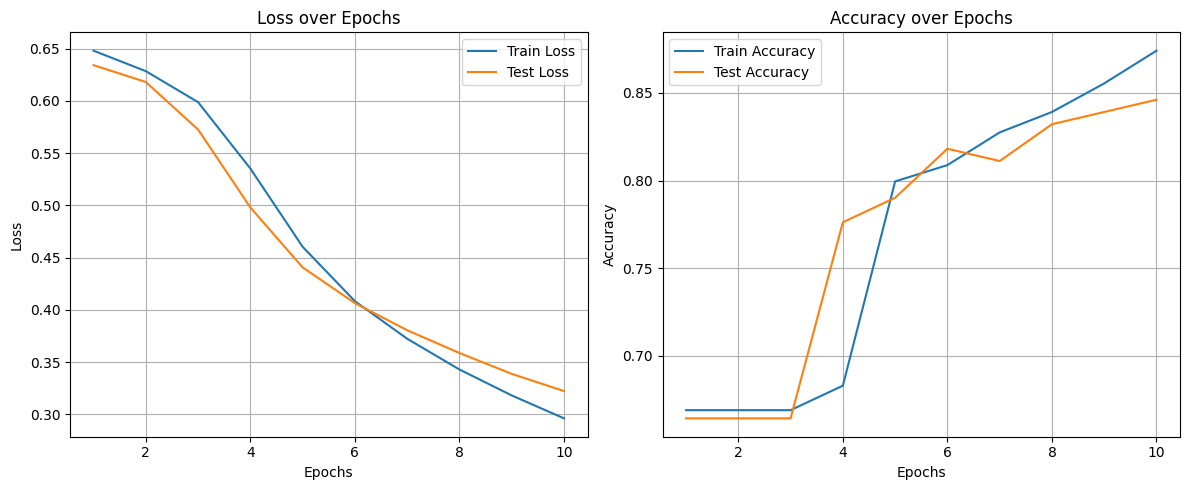

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
ckpt_path = "m3_model_weights.pth"

torch.save(
    {
        "epoch": epoch,               # optional
        "model_state": m3_model.state_dict(),
        "optimizer_state": optimizer.state_dict(),   # optional
    },
    ckpt_path
)

### LOAD LATER
# checkpoint = torch.load("m3_model_weights.pth", map_location="cpu")  # or "cuda:0"

# model.load_state_dict(checkpoint["model_state"])
# optimizer.load_state_dict(checkpoint["optimizer_state"])  # only if you saved it

# start_epoch = checkpoint.get("epoch", 0) + 1   # resume training if you like



In [ ]:
target_layer = m3_model.img_encoder.conv_block3[0]
grad_cam = GradCAM(model=m3_model, target_layer=target_layer)

In [ ]:
for batch in test_data_loader:
    input_dict = {
        "tabular": batch[0],
        "images": batch[1],
        "labels": batch[2]
    }
    if input_dict["labels"] == 1 and input_dict["images"].shape[1] == 2:
        print("Got it")
        break
    else:
        continue

cam_list = grad_cam.generate_cam(input_dict)

Got it


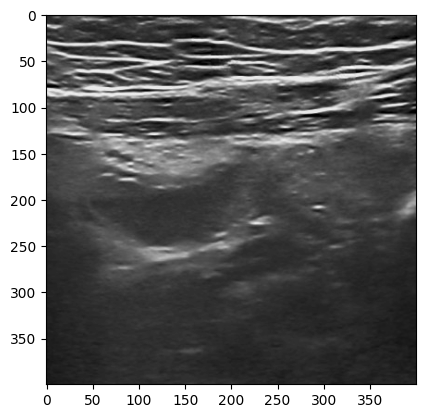

In [ ]:
plt.imshow(input_dict["images"][0, 0, 0], cmap="gray")

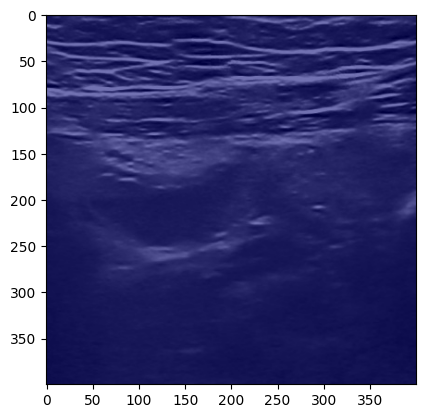

In [ ]:
plt.imshow(overlay_gradcam_on_image(input_dict["images"][0, 0, 0], cam_list[0][0, 0]))

In [ ]:
def ablation_test(model, data_loader):
    model.eval()

    total_full_input_acc = 0.0
    total_img_only_acc = 0.0
    total_tab_only_acc = 0.0

    for tabular_data, multi_view_data, labels in tqdm(data_loader):

        # Move to CUDA
        if device == "cuda":
            tabular_data = tabular_data.cuda()
            multi_view_data = multi_view_data.cuda()
            labels = labels.cuda()

            # Ensure labels are also float and have the same shape, for example:
            if labels.ndim == 1:
                labels = labels.unsqueeze(1).float()

        with torch.no_grad():
            # Full input
            full_output = model(tabular_data, multi_view_data)
            full_prob = torch.sigmoid(full_output)
            full_preds = (full_prob > 0.5).float()      # Threshold to get predictions (0 or 1)
            full_acc = (full_preds == labels).float().mean().item()
            total_full_input_acc += full_acc

            # Tabular-only
            zero_images = torch.zeros_like(multi_view_data)
            output_tab_only = model(tabular_data, zero_images)
            prob_tab_only = torch.sigmoid(output_tab_only)
            tab_only_preds = (prob_tab_only > 0.5).float()      # Threshold to get predictions (0 or 1)
            tab_only_acc = (tab_only_preds == labels).float().mean().item()
            total_tab_only_acc += tab_only_acc

            # Image-only
            zero_tabular = torch.zeros_like(tabular_data)
            output_img_only = model(zero_tabular, multi_view_data, tab_ablation=True)
            prob_img_only = torch.sigmoid(output_img_only)
            img_only_preds = (prob_img_only > 0.5).float()      # Threshold to get predictions (0 or 1)
            img_only_acc = (img_only_preds == labels).float().mean().item()
            total_img_only_acc += img_only_acc

    return {
        "Full prediction": total_full_input_acc / len(data_loader),
        "Tabular-only": total_tab_only_acc / len(data_loader),
        "Image-only": total_img_only_acc / len(data_loader),
    }


In [ ]:
ablation_test(m3_model, test_data_loader)

100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:04<00:00, 31.10it/s]


{'Full prediction': 0.8461538461538461,
 'Tabular-only': 0.8461538461538461,
 'Image-only': 0.6643356643356644}

In [ ]:
all_labels = []
all_preds = []
for tabular_data, multi_view_data, labels in tqdm(test_data_loader):
    # Move to CUDA
    if device == "cuda":
        tabular_data = tabular_data.cuda()
        multi_view_data = multi_view_data.cuda()
        labels = labels.cuda()

    outputs = m3_model(tabular_data, multi_view_data)

    # Compute predictions using a 0.5 threshold after sigmoid
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float()

    all_labels.append(labels.item())
    all_preds.append(preds.item())


100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:02<00:00, 62.60it/s]


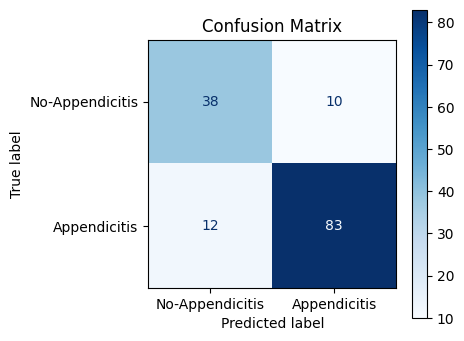

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
class_names = ["No-Appendicitis", "Appendicitis"]
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(4, 4))
display.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title("Confusion Matrix")
plt.show()


<a name="analysis"></a>
**4. Analysis of Results**
---

**Learning Curves:**

Both train and test loss decrease smoothly from about 0.65 to 0.30 over 10 epochs, with no large gap between them. Additionally, the test accuracy climbs from approximately 0.67 to 0.85, closely following train accuracy, which indicates good generalization and minimal over-fitting.

**Ablation Study:**

As we mentioned in our EDA insights, we worried about the tabular data being too good on its own (as the features strongly correlate with diagnosis). To test this concern, we performed an ablation study (by getting predictions using the full data, just the tabular data (with empty images), and with just image data (the tabular data embedding is just 0's)). The results from the ablation study indicate that our concerns were valid: the performance of the model with all the data is essentially the same as the performance of the model with just the tabular data, and the performance drops significantly if only the images are used. This indicates that the model is not making use of the image data at all. Therefore, the network is essentially ignoring the images at the moment.

**GradCAM**

When running GradCAM as a test on an image, no relevant regions are highlighted. This supports the findings from our ablation study that our model is not making good use of the image data in its predictions.

**Confusion Matrix:**

The model seems to be quite balanced in the types of errors it makes (the number of False Positives (=10) is approximately the same as the number of False Negatives (=12)). This indicates that the model is reasonably trustworthy in both classes.

**Summary:**

The model is quite stable in its training and there are no signs of overfitting. It also is balanced in its errors and achieves a pretty good test accuracy (=88%). However, the model is not making use of the multi-modal data and is effectively ignoring the multi-view aspect. This also results in a very poor GradCAM performance, as it seems like the ImageEncoder is not learning any useful representations.

<a name="next_steps"></a>
**5. Next Steps**
---

We think that our existing preprocessing pipeline is already quite good! One thing we would like to add is data augmentation for the images. We see this as a bit challenging, though, due to the fact that images are inherently linked to the tabular data and other views of a patient. The other thing we would like to address is the effectiveness of our model (especially in its usage of image data) and the effectiveness of visual interpretability.

Therefore, we would like to focus on the following aspects for the final milestone:

1. **Encourage image usage**. This could be done by introducing a large dropout in the tabular image encoder, which would force the network to rely on image data during training. This could also be achieved by pre-training the image encoder on this task (e.g., by adding another fully connected binary classification layer to it and training it for the diagnosis classification task. Then, we could simply remove the classification layer and use it just to extract the representation).
2. **Add a learning rate scheduler** and **train for more epochs** to see when we approach overfitting. This should allow us to extract the maximal performance from the model. We do want to make sure, however, that the model sufficiently uses both tabular and image data.
3. **Determine the best approach for visual interpretability**. We are currently just using GradCAM as a proof of concept, but we need to figure out a way to determine which view is the most relevant one in a prediction. This requires us to first have a model that effectively utilizes image data. Once we have that, we can get into a better exploration of this issue. We also are not sure whether GradCAM is the best visual interpretability method - we will check its performance and then potentially explore other methods.

*Note: we do identify one major issue: as data scientists, we are not really capable of properly evaluating the actual usefulness of the interpretability method. We can only make assumptions on what - from our limited perspective - seems like a valuable explanation. Checking whether this is actually useful for doctors would be interesting future work and could be investigated via user studies. This, however, is outside the scope of this class project.*

<a name="final"></a>
**6. Final Model Pipeline Setup**
---

#### **1. Data Preprocessing**
- *Tabular Data*
  - Feature Selection:
      - Retain only features with less than 50% missingness.
      - Drop redundant (e.g., Height, Weight), clinically irrelevant, or leakage-prone features.
  - Missing Value Handling:
      - Create binary missingness flags where informative (e.g., *Appendix_Diameter*).
      - KNN imputation for strongly correlated features.
      - Median (numerical) / mode (categorical) imputation otherwise.
      - Fill remaining missing values with 0.
  - Encoding:
      - Standardize numerical features.
      - One-hot encode multi-class categorical variables (drop first column).
      - Binary categorical features mapped to {0, 1}.
  - Train-Test-Split:
      - 75% training / 25% testing, stratified by diagnosis.
- *Multi-View Image Data*
  - Duplicate Removal:
      - Use hashing to detect and remove duplicate images per patient
  - Annotation Inpainting:
      - Apply DeepFill v2 to remove radiologist annotations.
  - Cropping & Resizing:
      - Center-crop and resize images to 400×400 pixels.
  - Normalization:
      - Normalize pixel values to [0,1].
  - Aggregation:
      - Aggregate all views into a single row per patient (up to 34 views).
      - Handle missing views dynamically (padding during batching).
  - Mask Creation:
      - Create binary masks indicating which images are real per patient.

#### **2. Dataset and DataLoader Setup**
- Dataset Class:
  - `MultiModalDataset` returns (tabular data, multi-view images, mask, label).
- Collate Function:
  - `multi_view_collate_fn` handles padding for variable number of views dynamically at runtime.

#### **3. Model Architecture**
- Separate Encoders:
  - Image Encoder:
    - 3 convolutional blocks (ReLU + pooling).
    - AdaptiveAvgPooling at final block for GradCAM compatibility.
    - Fully connected layer outputting 128-dimensional image embedding.
    - Pretrain this image encoder with an additional classification layer on this task. Remove the classification layer and then use it as the image encoder
  - Tabular Encoder:
    - MLP with one hidden layer (size 25).
    - Outputs 15-dimensional tabular feature embedding.
    - Dropout Layer (with dropout probability `0.5` to encourage model to rely on images)
  - Fusion Module:
    - Concatenates tabular and image embeddings.
    - MLP (64 hidden units) --> outputs a single logit (for binary classification).

#### **4. Training Setup**
- Loss Function:
  - Binary Cross Entropy with Logits (`BCEWithLogitsLoss`).
- Optimizer:
  - Adam optimizer with learning rate `1e-4`.
- Batch Size:
  - `1` (due to variable views per patient).
- Epochs:
  - Start with `10` (preliminary choice; monitor for early stopping if necessary).

#### **5. Evaluation Strategy**
- Primary Metrics:
  - Accuracy
  - Binary Cross Entropy Loss
  - Confusion Matrix
- Ablation Study:
  - Compare model using:
    - Full input (tabular + image)
    - Tabular-only input
    - Image-only input
- Interpretability:
  - Apply GradCAM on the last convolutional layer to generate saliency maps over ultrasound images.











